# Chapter 3 
# Starting with Machine Learning 3/3

# Contents #
***
- [ ] Linear regression
- [ ] The MNIST dataset
- [ ] Classifiers
- [ ] The nearest neighbor algorithm
- [x] Data clustering
- [x] The k-means algorithm

# Data clustering
***
A clustering problem consists in the selection and grouping of homogeneous items from a set of initial data. To solve this problem, we must: 

* Identify a resemblance measure between elements 
* Find out if there are subsets of elements that are similar to the measure chosen 

The algorithm determines which elements form a cluster and what degree of similarity unites them within the cluster. The clustering algorithms fall into the unsupervised methods, because we do not assume any prior information on the structures and characteristics of the clusters.


# The k-means algorithm
***
One of the most common and simple clustering algorithms is k-means, which allows subdividing groups of objects into k partitions on the basis of their attributes. Each cluster is identified by a point or centroid average.

__The algorithm follows an iterative procedure:__
1. Randomly select K points as the initial centroids. 
2. Repeat.
3. Form K clusters by assigning all points to the closest centroid.
4. Recompute the centroid of each cluster.
5. Until the centroids don't change.

<video src="imgs/Clustering_and_k-means.mp4#t=00:00:00,00:04:21" controls poster="imgs\k-means_clustering_algrithm.png" width="100%">
</video>

<video src="imgs/Clustering_and_k-means.mp4#t=00:04:23,00:07:34" controls poster="imgs\k-means_clustering_example.png" width="100%">
</video>

# Main features of k-means
***

* The popularity of the k-means comes from its convergence speed and its ease of implementation.
* In terms of the quality of the solutions, the algorithm does not guarantee achieving the global optimum. The quality of the final solution depends largely on the initial set of clusters and may, in practice, to obtain a much worse the global optimum solution. 

* Since the algorithm is extremely fast, you can apply it several times and produce solutions from which you can choose among most satisfying one. 

* Another disadvantage of the algorithm is that it requires you to choose the number of clusters (k) to find. 

* If the data is not naturally partitioned, you will end up getting strange results. Furthermore, the algorithm works well only when there are identifiable spherical clusters in the data. 

# Building the training set 
***

In [1]:
# Import all the necessary libraries to our simulation:
import matplotlib.pyplot as plt    
import numpy as np    
import tensorflow as tf    
import pandas as pd 

Pandas is an open source, easy-to-use data structure, and data analysis tool for the Python programming language. To install it, type the following command:

    sudo pip install pandas

In [2]:
# We must define the parameters of our problem. 
# The total number of points that we want to cluster is 1000 points:
num_vectors = 1000 

# The number of partitions you want to achieve by all initial:
num_clusters = 4 

# We set the number of computational steps of the k-means algorithm:
num_steps = 100 

# We initialize the initial input data structures:
x_values = []    
y_values = []    
vector_values = [] 

In [3]:
# The training set creates a random set of points, which is why we use the random.normal NumPy function, 
# allowing us to build the x_values and y_values vectors:
# wrong: for i in xrange(num_vectors):      
for i in range(num_vectors):      
    if np.random.random() > 0.5:        
        x_values.append(np.random.normal(0.4, 0.7))        
        y_values.append(np.random.normal(0.2, 0.8))      
    else:        
        x_values.append(np.random.normal(0.6, 0.4))        
        y_values.append(np.random.normal(0.8, 0.5)) 

# We use the Python zip function to obtain the complete list of vector_values:
# wrong: vector_values = zip(x_values,y_values)
vector_values = list(zip(x_values,y_values) )
    
#Then vector_values is converted into a constant, usable by TensorFlow:
vectors = tf.constant(vector_values)

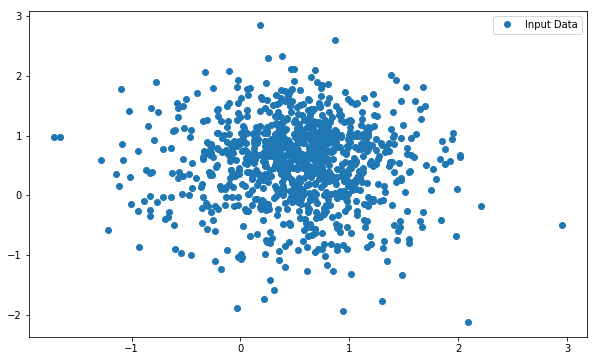

In [4]:
# We can see our training set for the clustering algorithm with the following commands:
plt.figure(figsize=(10,6))
plt.plot(x_values,y_values, 'o', label='Input Data')
plt.legend()    
plt.show()

#  Generating centroid
***

In [5]:
# After randomly building the training set, we have to generate (k = 4) centroid, 
# then determine an index using tf.random_shuffle:
n_samples = tf.shape(vector_values)[0]    
random_indices = tf.random_shuffle(tf.range(0, n_samples)) 

# By adopting this procedure, we are able to determine four random indices:
begin = [0,]    
size = [num_clusters,] 
size[0] = num_clusters 

# They have their own indexes of our initial centroids:
centroid_indices = tf.slice(random_indices, begin, size)    
centroids = tf.Variable(tf.gather(vector_values, centroid_indices))


# Cost functions and optimization 
***

The cost function we want to minimize for this problem is again the Euclidean distance between two points:

<center><img src="imgs\knn_equation.png" width="40%" height="40%"></center>

In [6]:
# In order to manage the tensors defined previously, vectors and centroids, 
# we use the TensorFlow function expand_dims, 
# which automatically expands the size of the two arguments:
expanded_vectors = tf.expand_dims(vectors, 0)    
expanded_centroids = tf.expand_dims(centroids, 1) 

# This function allows you to standardize the shape of the two tensors, 
# in order to evaluate the difference by the tf.sub method:
## wrong: vectors_subtration = tf.sub(expanded_vectors,expanded_centroids)
vectors_subtration = tf.subtract (expanded_vectors,expanded_centroids)

In [7]:
## debugging info
## expanded_vectors_x = tf.Print(expanded_vectors,[expanded_vectors,expanded_vectors.shape,'expanded_vectors'],message='Debug message:',summarize=100)
## expanded_centroids_x=tf.Print(expanded_centroids,[expanded_centroids,expanded_centroids.shape,'expanded_centroids'],message='Debug message:',summarize=100)

Finally, we build the euclidean_distances cost function, using the tf.reduce_sum function, which computes the sum of elements across the dimensions of a tensor, while the tf.square function computes the square of the vectors_subtration element-wise tensor:

In [8]:
euclidean_distances = tf.reduce_sum(tf.square(vectors_subtration), 2)    
assignments = tf.to_int32(tf.argmin(euclidean_distances, 0))

Here assignments is the value of the index with the smallest distance across the tensor euclidean_distances. Let us now turn to the optimization phase, the purpose of which is to improve the choice of centroids, on which the construction of the clusters depends. We partition the vectors (which is our training set) into num_clusters tensors, using indices from assignments. 

In [9]:
# The following code takes the nearest indices for each sample, 
# and grabs those out as separate groups using tf.dynamic_partition:
partitions = tf.dynamic_partition(vectors, assignments, num_clusters) 
    
# Finally, we update the centroids, using tf.reduce_mean on a single group to find the average of that group, forming its new centroid:
## wrong: update_centroids = tf.concat(0, [tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions]) 
update_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions],0 ) 

#To form the update_centroids tensor, we use tf.concat to concatenate the single one.


# Testing and algorithm evaluation
***

In [10]:
# It's time to test and evaluate the algorithm. The first procedure is to initialize all the variables and instantiate the evaluation graph:
## wrong: init_op = tf.initialize_all_variables() 
init_op = tf.global_variables_initializer()
sess = tf.Session()    
sess.run(init_op)

## sess.run(expanded_vectors_x)
## sess.run(expanded_centroids_x)

In [11]:
# Now we start the computation:
## wrong:     for step in xrange(num_steps):       
for step in range(num_steps):       
    _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments]) 
    #print("\n","-=",_, "\n centroid=",centroid_values, "\n assignment=",assignment_values,"\n")

# Let's display the result:

In [12]:
# The code for this visualization function is as follows:
def display_partition(x_values,y_values,assignment_values):        
        labels = []        
        colors = ["red","blue","green","yellow"]        
        ## wrong for i in xrange(len(assignment_values)):
        for i in range(len(assignment_values)):
            labels.append(colors[(assignment_values[i])])        
        color = labels        
        df = pd.DataFrame(dict(x =x_values,y = y_values ,color = labels ))
        fig, ax = plt.subplots()        
        ax.scatter(df['x'], df['y'], c=df['color'])        
        plt.show() 

It associates to each cluster its color by means of the following data structure:

    colors = ["red","blue","green","yellow"] 

It then draws them through the scatter function of matplotlib:
    
    ax.scatter(df['x'], df['y'], c=df['color'])

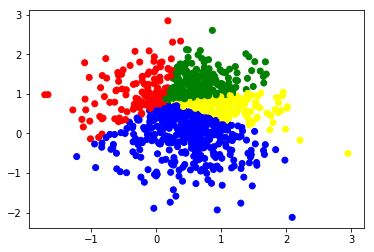

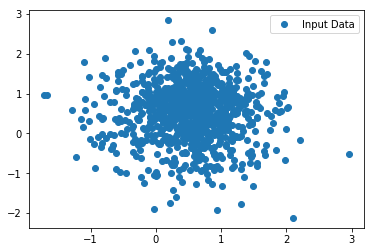

In [13]:
display_partition(x_values,y_values,assignment_values)    
plt.plot(x_values,y_values, 'o', label='Input Data')    
plt.legend()    
plt.show()